Erkennung von Distribution Shifts mithilfe des Kolmogorov-Smirnov-Test 


Comparing Dataset A and Dataset B for Age, p-value: 0.0000


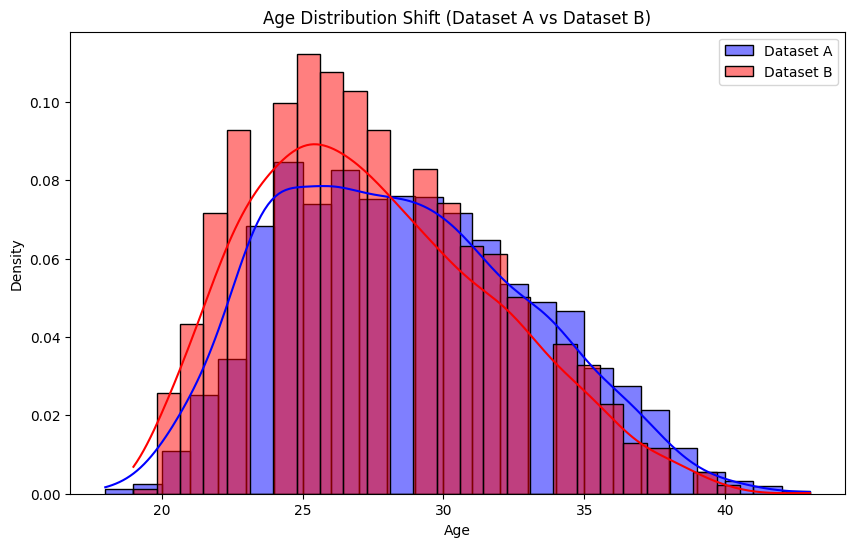


Comparing Dataset A and Dataset B for GamesPlayed, p-value: 0.0000


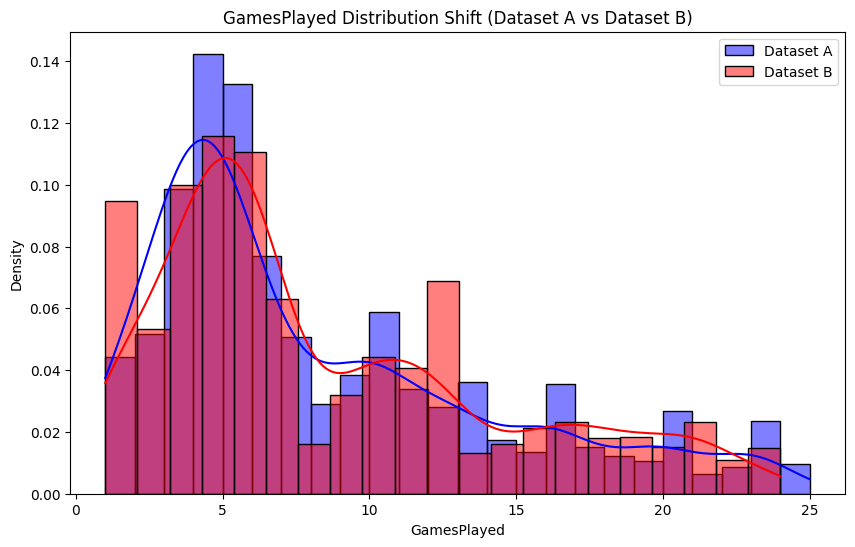


Comparing Dataset A and Dataset B for Wins, p-value: 0.0015


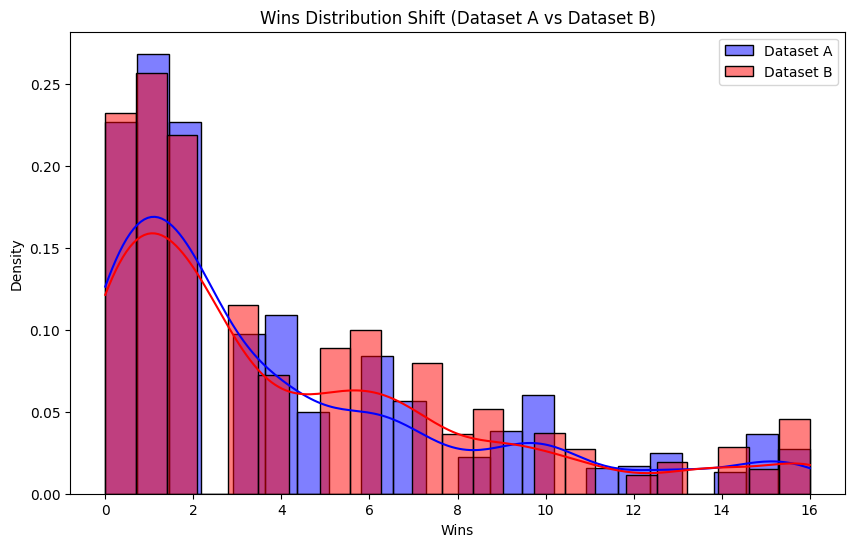


Comparing Dataset A and Dataset B for Losses, p-value: 0.0000


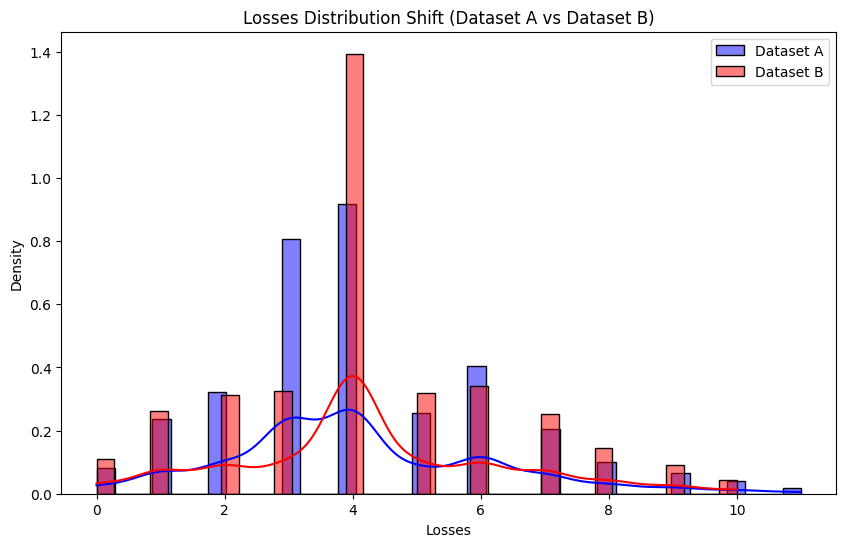


Comparing Dataset A and Dataset B for PointsScored, p-value: 0.0001


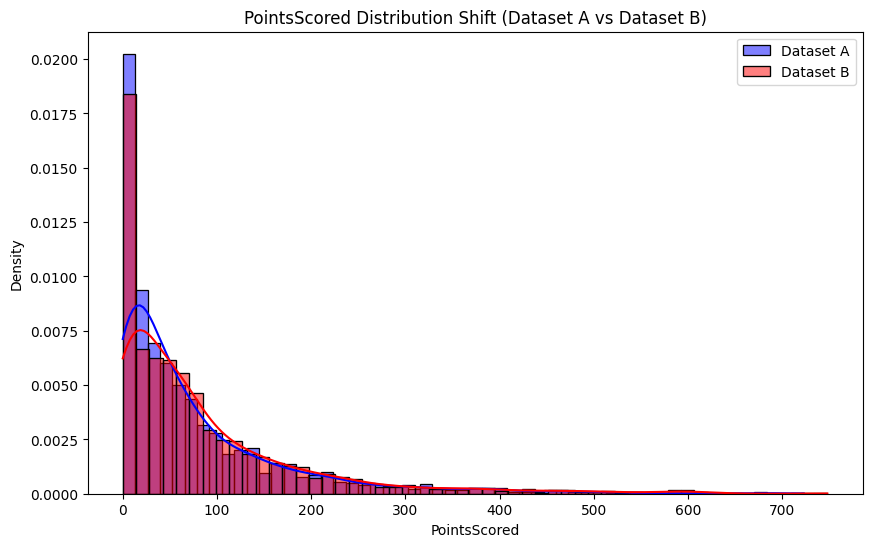


Comparing Dataset A and Dataset B for FG%, p-value: 0.0004


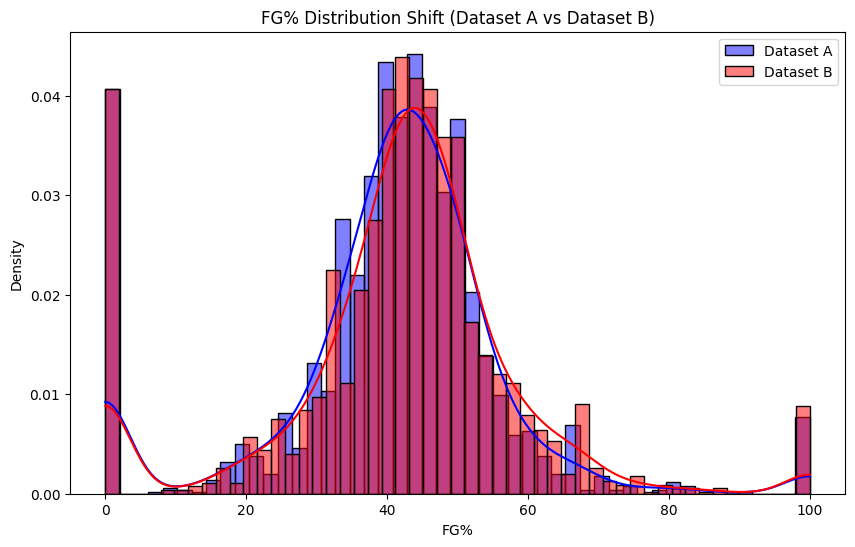


Comparing Dataset A and Dataset B for 3P%, p-value: 0.0000


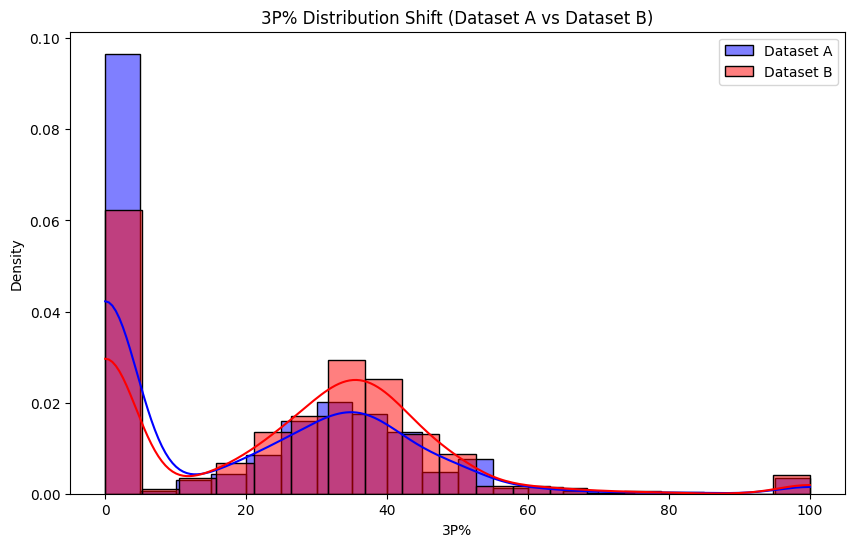


Comparing Dataset A and Dataset B for FT%, p-value: 0.0142


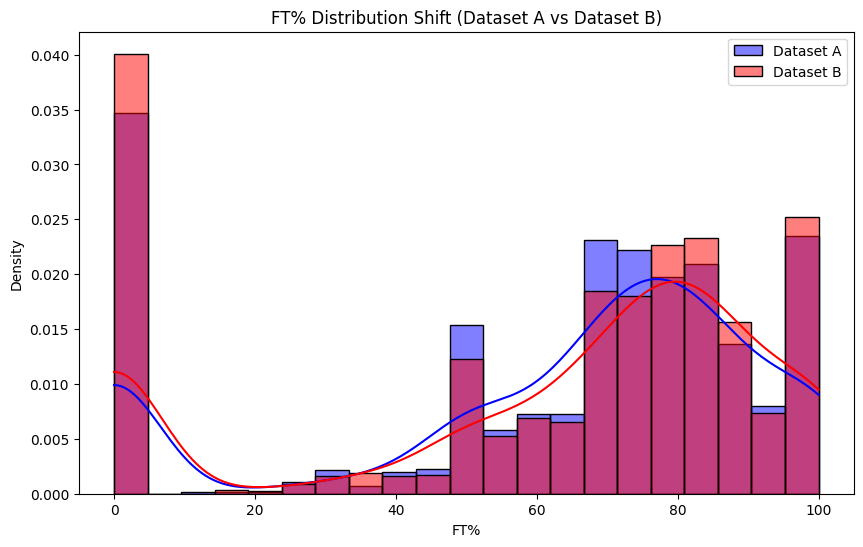


Comparing Dataset A and Dataset B for TotalRebounds, p-value: 0.0492


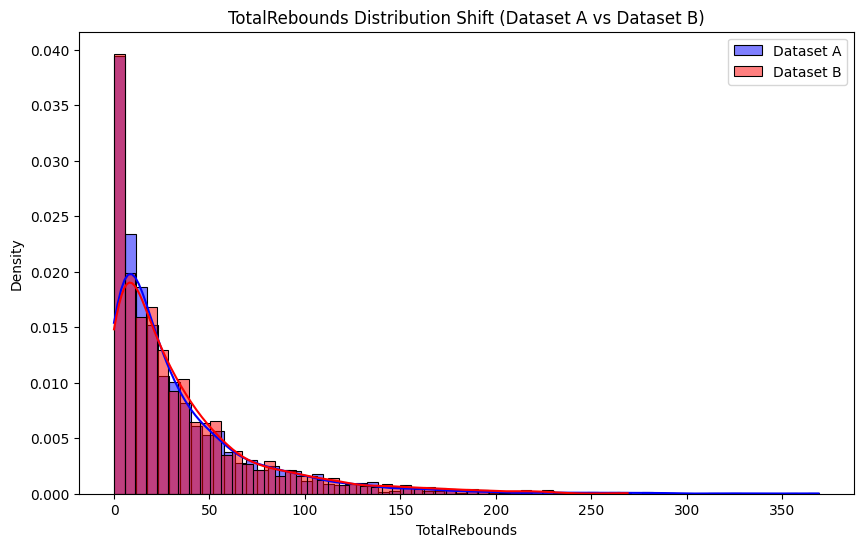


Comparing Dataset A and Dataset B for Assists, p-value: 0.0421


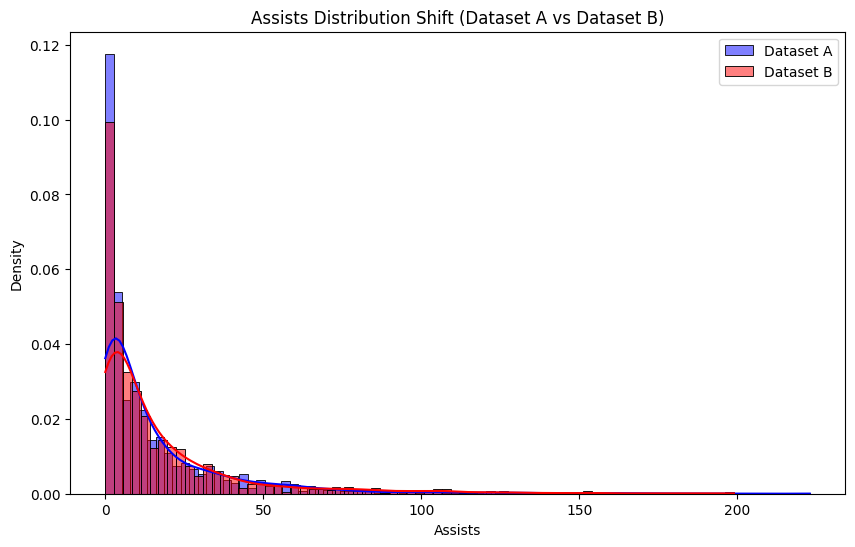


Comparing Dataset A and Dataset B for Blocks, p-value: 0.0302


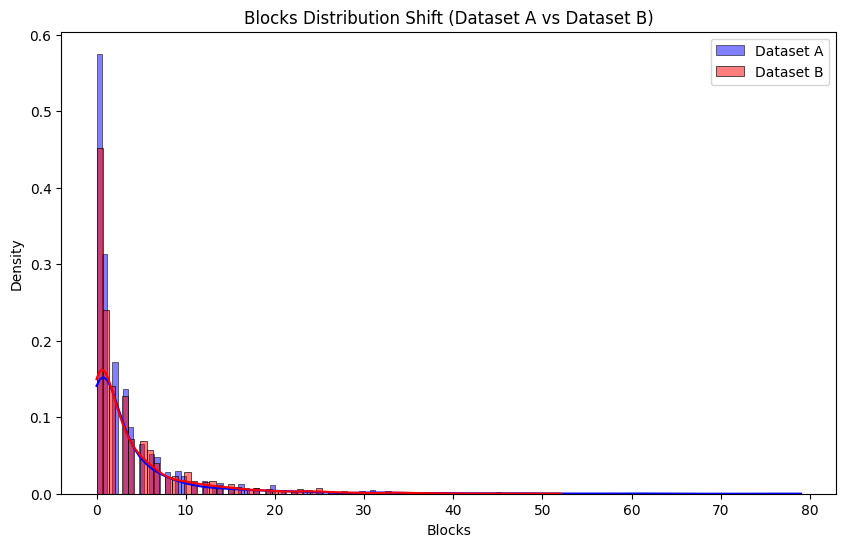


Comparing Dataset A and Dataset B for PersonalFouls, p-value: 0.0333


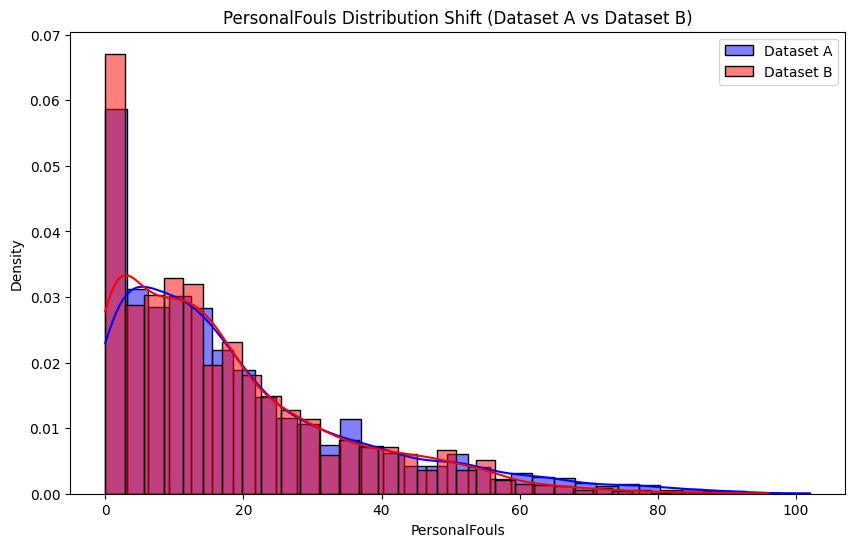


Significant shifts detected between Dataset A and Dataset B:
          Feature       p_value
0             Age  8.383652e-09
1     GamesPlayed  2.961833e-06
2            Wins  1.464456e-03
3          Losses  3.797673e-22
4    PointsScored  5.313277e-05
5             FG%  3.949611e-04
6             3P%  5.679248e-29
7             FT%  1.419868e-02
8   TotalRebounds  4.924765e-02
9         Assists  4.210154e-02
10         Blocks  3.023008e-02
11  PersonalFouls  3.326199e-02


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
file_path_a = './Source_Target/source_data_YEAR<=2009.csv'  # Adjust this path to your first CSV file location
file_path_b = './Source_Target/target_data_YEAR>2009.csv'  # Adjust this path to your second CSV file location

data_a = pd.read_csv(file_path_a)
data_b = pd.read_csv(file_path_b)

# Detect shifts for continuous variables using KS test
def detect_continuous_shifts(data_a, data_b, feature, alpha=0.05):
    significant_shifts = []
    
    # Perform KS test
    ks_stat, p_value = ks_2samp(data_a[feature], data_b[feature])
    
    # Check if the shift is significant
    if p_value < alpha:
        significant_shifts.append((feature, p_value))
    
    return significant_shifts

# Detect shifts for each feature
all_significant_shifts = []

# Continuous variables
for index in range(0,len(data_a.columns)):
    feature = data_a.columns[index]
    shifts = detect_continuous_shifts(data_a, data_b, feature)
    all_significant_shifts.extend(shifts)

# Create a DataFrame for significant shifts
columns = ['Feature', 'p_value']
significant_shifts_df = pd.DataFrame(all_significant_shifts, columns=columns)

# Output the significant shifts and visualize
for feature in significant_shifts_df['Feature'].unique():
    feature_shifts = significant_shifts_df[significant_shifts_df['Feature'] == feature]
    for _, row in feature_shifts.iterrows():
        p_value = row['p_value']
        
        print(f"\nComparing Dataset A and Dataset B for {feature}, p-value: {p_value:.4f}")
        
        # Visualize the shifts
        plt.figure(figsize=(10, 6))
        if feature in data_a.columns:
            sns.histplot(data_a[feature], color='blue', label='Dataset A', kde=True, stat="density")
            sns.histplot(data_b[feature], color='red', label='Dataset B', kde=True, stat="density")
            plt.xlabel(feature)
        else:
            # Create DataFrame for plotting
            data_a_df = data_a[feature].value_counts().reset_index()
            data_a_df.columns = [feature, 'Count']
            data_a_df['Dataset'] = 'Dataset A'
            
            data_b_df = data_b[feature].value_counts().reset_index()
            data_b_df.columns = [feature, 'Count']
            data_b_df['Dataset'] = 'Dataset B'
            
            plot_df = pd.concat([data_a_df, data_b_df])
            
            sns.barplot(x=feature, y='Count', hue='Dataset', data=plot_df)
            plt.xlabel(feature)
            plt.ylabel('Count')
        
        plt.title(f'{feature} Distribution Shift (Dataset A vs Dataset B)')
        plt.ylabel('Density' if feature in data_a.columns else 'Count')
        plt.legend()
        plt.show()

# Display the DataFrame with significant shifts
print("\nSignificant shifts detected between Dataset A and Dataset B:")
print(significant_shifts_df)